In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
import cv2

In [2]:
def get_SE(size,n):
    center = np.array([size/2,size/2])
    SE = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            v = [i+1,j+1]-center
            if sum(abs(v)**n)**(1/n) < size/2:
                SE[i,j] = 1
    return SE.T

In [4]:
def rgbquantize(rgbimage,quant_factor):
    out = cv2.normalize(rgbimage.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    quantized = np.floor(out/np.max(out).astype(np.float64)*0.99*quant_factor)+1
    quant_vals = np.float64(np.arange(quant_factor)+0.5)*(256/quant_factor)
    return quantized.astype(np.int32),quant_vals

In [5]:
# mat = np.random.random((100,100,3))
# rgbquantize(mat,12)

In [6]:
def ind2sub(array_shape, ind):
    stop_num = np.prod(array_shape)
    cols = []
    rows = []
    channels = []
    for i in ind:
        x,y,z = np.where(np.arange(stop_num).reshape(array_shape)+1==i)
        x+=1
        y+=1
        z+=1
        cols = cols + [x]
        rows = rows + [y]
        channels = channels + [z]
    return (np.array(rows).T, np.array(cols).T, np.array(channels).T)

In [7]:
# ind = np.array([3, 4, 5, 6])
# sz = np.array([12,12,12])
# ind2sub(sz,ind)

In [8]:
# a = np.array([1,2,3,4,5,6,7])
# a = -np.sort(-a)
# np.argsort(-a)
# # a,ind

In [185]:
# def color_hist(input_img, ncolors):
#     m,n,c = input_img.shape
#     input_img=input_img.astype(np.int8)
#     chist = np.zeros((ncolors,ncolors,ncolors))
#     for i in range(m):
#         for j in range(n):
#             print(i,j)
#             chist[input_img[i,j,0],input_img[i,j,1],input_img[i,j,2]] += 1
#     nonzeros = np.nonzero(chist)
#     r, g, b = ind2sub(chist.shape, nonzeros)
#     nonzero_freqs = chist[nonzeros]
#     nonzero_colors = np.array([r,g,b])
#     nonzero_freqs, inds = -np.sort(-nonzero_freqs),np.argsort(-nonzero_freqs)
#     nonzero_colors = nonzero_colors[inds,:]
#     return nonzero_colors, nonzero_freqs
def color_hist(img,colorLevels):
    #each color channel has to be divided into colorLevels number of bins:

    #Assume that we are working with a quantized image

    im = img.astype(int)

    chist = np.zeros((colorLevels+1,colorLevels+1,colorLevels+1))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            chist[im[i,j,0],im[i,j,1],im[i,j,2]] += 1

    nonzero_c = []
    nonzero_f = []
    for i in range(chist.shape[0]):
      for j in range(chist.shape[1]):
        for k in range(chist.shape[2]):
          if chist[i,j,k]!=0:
            nonzero_f.append(chist[i,j,k])
            nonzero_c.append((i,j,k))

    nf = nonzero_f
    zipped_lists = zip(nonzero_f, nonzero_c) 
    sorted_zipped_lists = sorted(zipped_lists,reverse=True) 
    nonzero_c = [element for _, element in sorted_zipped_lists]
    nonzero_f = nf.sort(reverse=True)

    
    return np.array(nonzero_c),np.array(nf)

In [186]:
def euclidean_norm(v):
    return np.sum(np.abs(v)**2)**(1/2)

In [187]:
def saliency_map(input_img):
    m,n,c = input_img.shape
    quant_factor = 12
    # lab_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2LAB)
    rgb_quant, rgb_vals = rgbquantize(input_img,quant_factor)
    nzero_colors, nzero_freqs = color_hist(rgb_quant,quant_factor)
    nzc_shape = nzero_colors.shape
    nzero_colors=nzero_colors.reshape(nzc_shape[0],1,3)
    lab_nzero_colors = cv2.cvtColor(nzero_colors.astype(np.uint8), cv2.COLOR_RGB2LAB)
    nzero_colors = nzero_colors.reshape(nzc_shape)
    nonzeros = nzero_colors.shape[0]
    color_dict = np.zeros((quant_factor,quant_factor,quant_factor)).astype(np.int32)
    for i in range(nonzeros):
        color_dict[nzero_colors[i,0]-1,nzero_colors[i,1]-1,nzero_colors[i,2]-1] = i
    saliences = np.zeros((nonzeros,1))
    for i in range(nonzeros):
        for j in range(nonzeros):
            saliences[i] = saliences[i] + euclidean_norm(lab_nzero_colors[i,:]-lab_nzero_colors[j,:])*nzero_freqs[j]
    saliences /= np.max(saliences)
    saliency_map = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            # print(color_dict[rgb_quant[i,j,0],rgb_quant[i,j,1],rgb_quant[i,j,2]])
            saliency_map[i,j] = saliences[color_dict[rgb_quant[i,j,0]-1,rgb_quant[i,j,1]-1,rgb_quant[i,j,2]-1]]
    return saliency_map

In [292]:
def otsuThresholding(image):
    thresh = threshold_otsu(image)
    print(thresh)
    binary = image > thresh-0.1
    return binary.astype(np.uint8)

In [305]:
def get_mask(img,se_noise,se_holes):
    s_img = saliency_map(img)
    s_img_t = otsuThresholding(s_img)
    # plt.imshow(s_img_t,cmap='gray')
    # dots_removed = cv2.morphologyEx(s_img_t, cv2.MORPH_OPEN, se_noise.astype(np.uint8))
    holes_removed = cv2.morphologyEx(s_img_t,cv2.MORPH_CLOSE,se_holes.astype(np.uint8))
    return holes_removed

In [306]:
def histEqual(im):
    im_hist, im_bins = np.histogram(im,density=True)
    im_cdf = np.round((np.cumsum(im_hist))*255)
    im_cdf /= im_cdf[-1]
    result = np.round(np.interp(im,im_bins[:-1],im_cdf)*255)
    return result

In [307]:
def colorHistEqual(im):
    hist_eqIm = np.zeros(im.shape)
    hist_eqIm[:,:,0] = histEqual(im[:,:,0])
    hist_eqIm[:,:,1] = histEqual(im[:,:,1])
    hist_eqIm[:,:,2] = histEqual(im[:,:,2])
    return hist_eqIm.astype(np.uint8)

0.6965380102546935


(-0.5, 249.5, 249.5, -0.5)

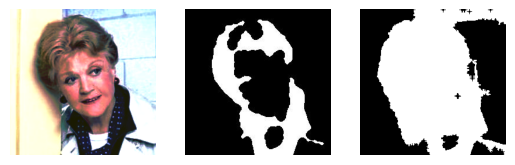

In [309]:
comp_img = cv2.imread('images/saliency-map/Angela_Lansbury_smap_0002.jpg')
comp_img = cv2.cvtColor(comp_img, cv2.COLOR_BGR2RGB)
# Read in a test images
img = cv2.imread('images/raw/Angela_Lansbury_0002.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = colorHistEqual(img)

# Form structuring elements for morphological image processing to eliminate small regions and close holes
se_noise = get_SE(15,1)
se_holes = get_SE(10,0.5)

# Get the mask processed using these structuring elements
mask = get_mask(img, se_noise, se_holes)
# plt.imshow(mask,cmap='gray')
# Label contiguous regions
regions,rlabelled = cv2.connectedComponents(mask,connectivity=8)


# Set a minimum region size to eliminate small regions
MIN_REGION_SIZE = 2000

# Eliminate all small regions and decrease region labels as necessary
for i in range(1,regions+1):
    num = np.sum(np.sum(rlabelled == i,axis=0))
    if num<MIN_REGION_SIZE:
        rlabelled = rlabelled-rlabelled*(rlabelled==i)

leftovers = np.unique(rlabelled)
new_labels = 1

for i in range(1,leftovers.shape[0]):
    rlabelled[rlabelled==leftovers[i]] = new_labels
    new_labels+=1

# Show regions shaded in different shades of gray
plt.subplot(1,3,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(132)
plt.imshow(comp_img)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(rlabelled/np.max(rlabelled),cmap='gray')
plt.axis('off')